# Import packages

In [1]:
import os
import re
import time
import requests
import numpy as np
import pandas as pd
from scipy.stats import t as T
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import ttest_1samp
from statsmodels.api import OLS, add_constant

import yahoo_crawler
yc = yahoo_crawler.yahoo_crawler()

yahooo_crawler


In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.facecolor'] = '1.'
plt.rcParams["axes.axisbelow"] = False

# Fetch yahoo finance stock data

In [3]:
def get_stock_data(symbol, start, end,):
    t = time.time()
    cookie,crumb = yc.get_yahoo_crumb_cookie()

    symbol = symbol# stock id
    params = {'period1' : start,
              'period2' : end,
              'interval': '1d',
              'events'  : 'history',
              'crumb'   : crumb}
    df = yc.GetStockPrice(symbol = symbol,
                               params = params,
                               request_type = 'post')
    
    # set date as index
    df = df.set_index('Date')
    df.sort_index(inplace = True)
    
    t2 = time.time() - t
    print(str(round(t2,4))+' seconds elapsed...')
    
    return df[['Adj Close']]

In [4]:
# define trading dates with S&P index
SP500          = get_stock_data(symbol = '^GSPC', start = '2014-12-01', end = '2019-04-19')
standard_index = SP500.index

Connected! It's the 1/200 try...
1.4219 seconds elapsed...


In [5]:
def reindex_data(symbol, tweets_date, standard_index = standard_index, how = 'test'):
    
    assert how in ['test', 'train'], 'Parameter *how* must be either \'test\' or \'train\'!'
    
    if how == 'test':
        start = standard_index[ standard_index <  tweets_date][-11]
        end   = standard_index[ standard_index >= tweets_date][ 11]

        df = get_stock_data(symbol = symbol, start = start, end = end)

        df = df.reindex(standard_index)

        df_ = pd.concat([ df[ df.index <  tweets_date ].tail(10),
                          df[ df.index >= tweets_date ].head(11) ])
    
    elif how == 'train':
        start = standard_index[ standard_index <  tweets_date][-252]
        end   = standard_index[ standard_index >= tweets_date][  11]

        df = get_stock_data(symbol = symbol, start = start, end = end)

        df = df.reindex(standard_index)

        df_ = pd.concat([ df[ df.index <  tweets_date ].tail(251),
                          df[ df.index >= tweets_date ].head(11) ])
        
    return df_

# Fetch marked tweets data

In [6]:
tweets = pd.read_excel('mentioned_stock.xlsx')
tweets.columns = [x.replace(' ', '') for x in tweets.columns]
tweets['ticker'] = tweets['ticker'].apply(lambda x: x.replace(' ', ''))
tweets.head()

,date,company,ticker,type,subject
0,2019-03-20 20:51:41,Ford,F,1,new investemetn in US
1,2019-03-17 22:27:27,General Motors,GM,-1,dissatified with negitation result
2,2019-03-14 16:18:40,Toyota,TM,1,favorable news due to new progress of nafta deal
3,2019-02-27 09:20:25,Fiat Chrysler,FCAU,1,Job adding
4,2018-11-29 11:37:14,General Motors,GM,-1,irony statement


In [7]:
tweets['date'].min()

Timestamp('2016-11-17 21:51:00')

In [8]:
tweets_i = tweets.iloc[2,:]
tweets_i

date                                    2019-03-14 16:18:40
company                                              Toyota
ticker                                                   TM
type                                                      1
subject    favorable news due to new progress of nafta deal
Name: 2, dtype: object

In [9]:
symbol = tweets_i['ticker']
symbol

'TM'

In [10]:
def my_normalize(df):
    df = df.copy()
    df -= df.mean()
    df /= df.std()
    return df

In [11]:
def fetch_data_set(symbol, tweets_date, plot = False):
    ''' Prepare dataset
    '''
    
    dict_ = {}
    ###################################################################################################
    #1, Prepare stock price series
    S_i = reindex_data(symbol = symbol, tweets_date = tweets_date, how = 'train')

    S_m = SP500.reindex(S_i.index)

    df = pd.concat([S_i, S_m ], axis = 1)
    df.columns = ['S_i', 'S_m']
    
    assert len(df[df['S_i'] != df['S_i']]) < 10, 'Missing values of stock %s are more than 10!'%symbol
    
    # fillna for stocks
    df = df.fillna(method = 'pad').fillna(method = 'bfill')
    
    assert len(df[df['S_i'] != df['S_i']]) == 0, 'Failed to fillna for tock %s!'%symbol
    
    dict_['price'] = df.copy()
    ###################################################################################################
    #2, Prepare stockprice series
    
    # calculate log return of stock_i and S&P500
    ret = np.log(df).diff().dropna()
    
    dict_['return'] = ret.copy()
    
    # regression R_i against R_m
    X = add_constant( ret['S_m'].iloc[: 240] )
    model = OLS( ret['S_i'].iloc[: 240], X ).fit()
    
    
    # predict S_i
    X = add_constant( ret['S_m'] )
    R_i_pred = model.predict(X)
    
    AR = ret['S_i'] - R_i_pred
    
    # store price, return, parameters, t values, and p values, AR
    dict_.update( {
        'price'   : df.copy(),
        'return'  : ret.copy(),
        'params'  : model.params ,
        't_values': model.tvalues, 
        'p_values': model.pvalues,
        'AR'      : AR.copy()
                 } )
    
    if plot:
        fig = plt.figure(figsize = [10, 6])
        
        ax1 = fig.add_subplot(221)
        ax1.plot(my_normalize(df['S_i']), label = symbol)
        ax1.plot(my_normalize(df['S_m']), label = 'S&P500' )
        ax1.set_ylabel('Normalize price serires')
        ax1.spines['top'  ].set_color('none')
        ax1.spines['left' ].set_color('none')
        ax1.spines['right'].set_color('none')
        ax1.autoscale(enable=True, axis='x', tight=True)
        ax1.legend(loc = 'best')
        ax1.grid(linestyle = ':', axis = 'y')
        plt.xticks(rotation = 15)
        
        ax2 = fig.add_subplot(222)
        ax2.plot(ret['S_i'], '-*', label = '%s log return'%symbol)
        ax2.plot(ret['S_m'], '-*', label = 'S&P500 log return' )
        ax2.set_ylabel('Log Return')
        ax2.spines['top'  ].set_color('none')
        ax2.spines['left' ].set_color('none')
        ax2.spines['right'].set_color('none')
        ax2.autoscale(enable=True, axis='x', tight=True)
        ax2.legend(loc = 'best')
        ax2.grid(linestyle = ':', axis = 'y')
        ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))
        plt.xticks(rotation = 15)
        
        ax3 = fig.add_subplot(212)
        ax3.plot(AR, '-*', label = '%s AR'%symbol)
        ax3.set_ylabel('AR')
        ax3.spines['top'  ].set_color('none')
        ax3.spines['left' ].set_color('none')
        ax3.spines['right'].set_color('none')
        ax3.autoscale(enable=True, axis='x', tight=True)
        ax3.legend(loc = 'best')
        ax3.grid(linestyle = ':', axis = 'y')
        ax3.yaxis.set_major_formatter(mtick.PercentFormatter(1))
        plt.xticks(rotation = 15)
        
        plt.suptitle('Price, Return, and AR of %s vs. S&P500'%symbol, fontsize = 20)
        plt.show()
        
    return dict_

Connected! It's the 1/200 try...
1.0313 seconds elapsed...


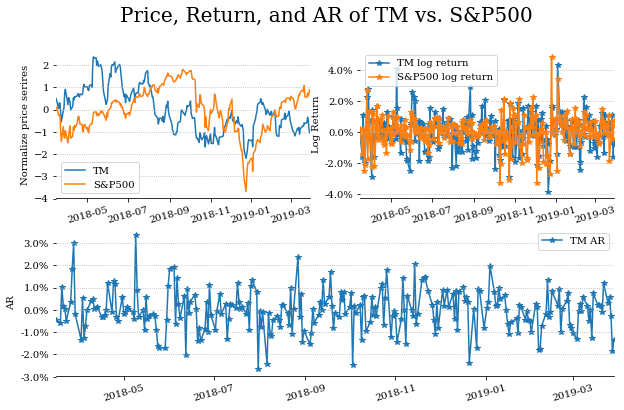

dict_keys(['price', 'return', 'params', 't_values', 'p_values', 'AR'])

In [12]:
dict_ = fetch_data_set(symbol, tweets_i['date'], plot = True)
dict_.keys()

In [13]:
mega_dict = {}

t = time.time()

for i in range( tweets.shape[0] ):
    tweets_i    = tweets.iloc[i, :]
    symbol      = tweets_i['ticker'].replace(' ', '')
    tweets_date = tweets_i['date']
    
    
    try:
        mega_dict[ '%s %s'%(symbol,tweets_date) ] = fetch_data_set(symbol, tweets_date, plot = False)
        print('Successfully fetched data for %s...'%symbol)
        print('==========================================\n')
    
    except Exception as e:
        print('Failed to fetch data for %s!'%symbol)
        print(e)
        print('==========================================\n')
    
        
print(time.time() - t,'sec(s) elapsed...')

Connected! It's the 1/200 try...
0.7969 seconds elapsed...
Successfully fetched data for F...

Connected! It's the 1/200 try...
0.7812 seconds elapsed...
Successfully fetched data for GM...

Connected! It's the 1/200 try...
0.8437 seconds elapsed...
Successfully fetched data for TM...

Connected! It's the 1/200 try...
0.6562 seconds elapsed...
Successfully fetched data for FCAU...

Connected! It's the 1/200 try...
0.5625 seconds elapsed...
Successfully fetched data for GM...

Connected! It's the 1/200 try...
0.5781 seconds elapsed...
Successfully fetched data for GM...

Connected! It's the 1/200 try...
0.6406 seconds elapsed...
Successfully fetched data for AAPL...

Connected! It's the 1/200 try...
0.5938 seconds elapsed...
Successfully fetched data for TRCO...

Connected! It's the 1/200 try...
0.8281 seconds elapsed...
Successfully fetched data for SBGI...

Connected! It's the 1/200 try...
0.6875 seconds elapsed...
Successfully fetched data for NVS...

Connected! It's the 1/200 try...

In [14]:
mega_dict.keys()

dict_keys(['F 2019-03-20 20:51:41', 'GM 2019-03-17 22:27:27', 'TM 2019-03-14 16:18:40', 'FCAU 2019-02-27 09:20:25', 'GM 2018-11-29 11:37:14', 'GM 2018-11-27 19:05:39', 'AAPL 2018-08-10 22:47:45', 'TRCO 2018-07-25 00:39:16', 'SBGI 2018-07-25 00:39:16', 'NVS 2018-07-19 10:23:14', 'PFE 2018-07-10 22:37:28', 'PFE 2018-07-09 17:08:29', 'HOG 2018-06-26 11:37:51', 'AMZN 2018-04-03 13:55:37', 'FOXA 2018-03-06 13:07:08', 'FCAU 2018-01-28 13:18:33', 'JPM 2018-01-24 11:58:58', 'DIS 2018-01-24 11:58:58', 'CCF 2018-01-24 11:58:58', 'AAPL 2018-01-17 23:28:30', 'FCAU 2018-01-12 02:53:05', 'TM 2018-01-11 04:29:02', 'AMZN 2017-12-29 13:04:09', 'AVGO 2017-11-02 20:33:18', 'AAL 2017-09-22 17:54:59', 'AMZN 2017-08-16 10:12:45', 'MRK 2017-08-14 12:54:47', 'AMZN 2017-07-25 02:36:17', 'MRK 2017-07-21 03:31:45', 'PFE 2017-07-21 03:31:45', 'GLW 2017-07-21 03:31:45', 'AMZN 2017-07-21 03:31:45', 'RXN 2017-05-07 22:58:47', 'F 2017-03-28 10:36:02', 'XOM 2017-03-06 16:19:00', 'INTC 2017-02-08 19:22:33', 'JWN 2017-0

In [15]:
mega_dict['F 2019-03-20 20:51:41'].keys()

dict_keys(['price', 'return', 'params', 't_values', 'p_values', 'AR'])

# Summarize OLS result

In [16]:
def label_sig(p_value):
    ''' Lable significance level accorning p_value
    '''
    if p_value > 0.1:
        return ''
    elif p_value <= 0.1 and p_value > 0.05:
        return '*'
    elif p_value <= 0.05 and p_value > 0.01:
        return '**'
    elif p_value <= 0.01:
        return '***'

In [17]:
def summary_OLS(mega_dict):
    ''' Summarize OLS result
    '''
    summary = pd.DataFrame()
    for k, v in zip( mega_dict.keys(), mega_dict.values() ):
        symbol = re.findall(r'(\w+)\s2', k)[0]
        date   = pd.to_datetime(re.findall(r'%s (.*)'%symbol, k)[0])
        
        company = tweets[ (tweets['ticker'] == symbol) & (tweets['date'] == date) ]['company'].values[0]
        
        intercept = '%.5f(%.2f)%s'%( 
                                v['params'  ]['const'],
                                v['t_values']['const'],
                                label_sig(v['p_values']['const'])
                                    )
        
        slope = '%.2f(%.2f)%s'%( 
                                v['params'  ]['S_m'],
                                v['t_values']['S_m'],
                                label_sig(v['p_values']['S_m'])
                                    )
        
        summary = summary.append( { 
                                'Stock'    : company,
                                'Intercept': intercept, 
                                'Slope'    : slope
                                    } ,ignore_index=True)
    return summary[['Stock', 'Intercept', 'Slope']]

regression_res = summary_OLS(mega_dict)
regression_res.to_csv('coefficients_from_market_model_regression.csv')
regression_res.head()

,Stock,Intercept,Slope
0,Ford,-0.00089(-0.88),0.84(8.57)***
1,General Motors,0.00022(0.20),0.92(8.45)***
2,Toyota,-0.00022(-0.37),0.70(12.15)***
3,Fiat Chrysler,-0.00158(-1.08),1.22(8.73)***
4,General Motors,-0.00074(-0.67),0.95(8.11)***


# AAR test

In [18]:
def collect_same_emotion(mega_dict = mega_dict, emotion = 1.):
    ''' Collect data set with the same emotion
    '''
    data_lst = []
    for k, v in zip( mega_dict.keys(), mega_dict.values() ):
        symbol = re.findall(r'(\w+)\s2', k)[0]
        date   = pd.to_datetime(re.findall(r'%s (.*)'%symbol, k)[0])
        
        emotion_ = tweets[ (tweets['ticker'] == symbol ) \
                         & (tweets['date'  ] == date   ) ]['type'].values[0]
        
        if emotion_ == emotion:
            
            data_lst.append( v['AR'].reset_index(drop = True) )
    return data_lst

In [19]:
data_pos = collect_same_emotion(emotion =  1)

data_neg = collect_same_emotion(emotion = -1)

print('Positive sample size is %s, Negative sample size is %s.'%( len(data_pos), len(data_neg) ))

Positive sample size is 34, Negative sample size is 20.


In [20]:
def summary_AAR(emotion = 1):
    ''' Summarize AAR for specific emotion
    '''
    data = collect_same_emotion(emotion = emotion)
    
    df = pd.concat( data, axis = 1 )
    
    AAR = df.tail(21).mean(axis = 1)
    
    t_test_res = df.tail(21).apply(lambda x: pd.Series([ttest_1samp(x , 0).statistic, 
                                                        ttest_1samp(x , 0).pvalue    ]),axis = 1)
    report = pd.concat([AAR, t_test_res], axis = 1)
    report.index = np.arange(-10, 11, 1)
    
    report.columns = ['AAR', 't_statistic', 'p_values']
    
    report['AAR'        ] = report.apply(lambda x: "{:.2%}".format(x['AAR']) + label_sig(x['p_values']), axis = 1)
    report['t_statistic'] = report['t_statistic'].apply(lambda x: round(x, 4))
    report['p_values'   ] = report['p_values'   ].apply(lambda x: round(x, 4))
    return report

In [21]:
pos_AAR_summary = summary_AAR(emotion =  1)
pos_AAR_summary.to_csv('aar_positive_tweets.csv')

neg_AAR_summary = summary_AAR(emotion = -1)
neg_AAR_summary.to_csv('aar_negative_tweets.csv')

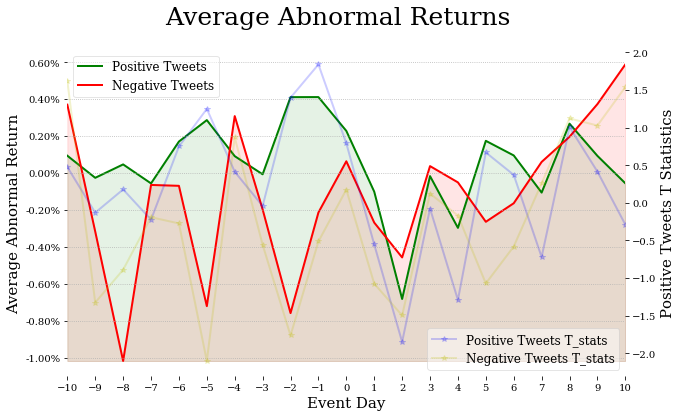

In [22]:
arr_pos = pd.concat(data_pos, axis = 1).tail(21).mean(axis = 1)
arr_pos.index = np.arange(-10, 11, 1)

arr_neg = pd.concat(data_neg, axis = 1).tail(21).mean(axis = 1)
arr_neg.index = np.arange(-10, 11, 1)

fig = plt.figure(figsize = [10, 6])
ax = fig.add_subplot(111)

ax.plot(arr_pos, 'g-', label = 'Positive Tweets', lw = 2)
ax.plot(arr_neg, 'r-', label = 'Negative Tweets', lw = 2)

lim = min( arr_pos.min(), arr_neg.min() )
ax.fill_between(arr_pos.index, lim, arr_pos, color = 'green', alpha = 0.1)
ax.fill_between(arr_neg.index, lim, arr_neg, color = 'red'  , alpha = 0.1)

ax.grid(axis = 'y', linestyle = ':')
ax.spines['top'   ].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'  ].set_color('none')
ax.spines['right' ].set_color('none')
ax.legend(loc = 'upper left', fontsize = 12, fancybox=True, framealpha=0.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_xlabel('Event Day', fontsize = 15)
ax.set_ylabel('Average Abnormal Return', fontsize = 15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_xticks(np.arange(-10, 11, step=1))

ax2 = ax.twinx()
ax2.plot(pos_AAR_summary['t_statistic'], 'b-*', label = 'Positive Tweets T_stats', lw = 2, alpha = 0.2)
ax2.plot(neg_AAR_summary['t_statistic'], 'y-*', label = 'Negative Tweets T_stats', lw = 2, alpha = 0.2)
ax2.spines['top'   ].set_color('none')
ax2.spines['bottom'].set_color('none')
ax2.spines['left'  ].set_color('none')
ax2.spines['right' ].set_color('none')
ax2.autoscale(enable=True, axis='x', tight=True)
ax2.legend(loc = 'lower right', fontsize = 12, fancybox=True, framealpha=0.5)
ax2.set_ylabel('Positive Tweets T Statistics', fontsize = 15)

plt.suptitle('Average Abnormal Returns', fontsize = 25)
plt.show()

In [23]:
pos_AAR_summary

,AAR,t_statistic,p_values
-10,0.09%,0.4770,0.6365
-9,-0.03%,-0.1302,0.8972
-8,0.05%,0.1787,0.8592
-7,-0.06%,-0.2237,0.8244
-6,0.17%,0.7500,0.4586
-5,0.29%,1.2494,0.2203
-4,0.09%,0.4139,0.6816
-3,-0.01%,-0.0414,0.9672
-2,0.41%,1.3986,0.1713
-1,0.41%*,1.8404,0.0747


In [24]:
neg_AAR_summary

,AAR,t_statistic,p_values
-10,0.37%,1.6221,0.1212
-9,-0.32%,-1.3255,0.2007
-8,-1.02%,-0.8890,0.3851
-7,-0.06%,-0.1905,0.8510
-6,-0.07%,-0.2731,0.7878
-5,-0.72%**,-2.1019,0.0491
-4,0.31%,0.8707,0.3948
-3,-0.20%,-0.5564,0.5844
-2,-0.76%*,-1.7628,0.0940
-1,-0.21%,-0.5131,0.6138


# CAAR t test

In [25]:
def calculate_CAAR(emotion = 1):
    ''' Calculate CAAR according to given emotion
    '''
    data = collect_same_emotion(emotion = emotion)
    
    size = len( data )
    
    df = pd.concat( data, axis = 1 )
    
    sigma = df.head(240).mean(axis = 1).std()
    
    AAR = df.tail(21).mean(axis = 1)
    
    AAR.index = np.arange(-10, 11, 1)
    
    CAAR = df.tail(21).cumsum().mean(axis = 1)
    
    t_test_res = df.tail(21).cumsum().apply(lambda x: pd.Series([ttest_1samp(x , 0).statistic, 
                                                                 ttest_1samp(x , 0).pvalue    ]),axis = 1)
    
    report = pd.concat([CAAR, t_test_res], axis = 1)
    report.index = np.arange(-10, 11, 1)
    
    report.columns = ['CAAR', 't_statistic', 'p_values']
    return report

In [26]:
def summary_CAAR(emotion = 1):
    ''' Summarize CAAR for specific emotion
    '''
    report = calculate_CAAR(emotion)
    
    report['CAAR'       ] = report.apply(lambda x: "{:.2%}".format(x['CAAR']) + label_sig(x['p_values']), axis = 1)
    report['t_statistic'] = report['t_statistic'].apply(lambda x: round(x, 4))
    report['p_values'   ] = report['p_values'   ].apply(lambda x: round(x, 4))
    return report

In [27]:
pos_CAAR_summary = summary_CAAR(emotion =  1)
pos_CAAR_summary.to_csv('caar_positive_tweets.csv')

neg_CAAR_summary = summary_CAAR(emotion = -1)
neg_CAAR_summary.to_csv('caar_negative_tweets.csv')

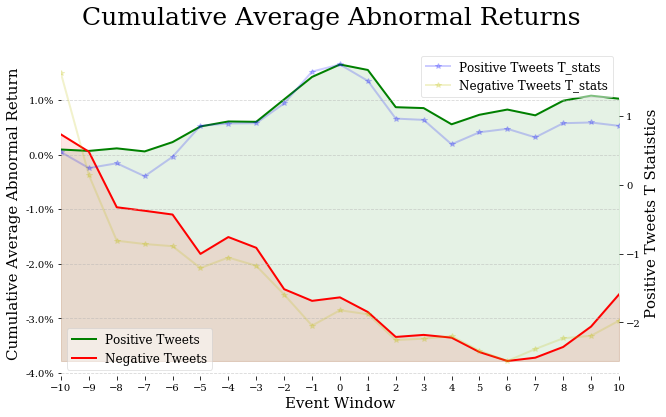

In [28]:
carr_pos = calculate_CAAR( 1)['CAAR']

carr_neg = calculate_CAAR(-1)['CAAR']

fig = plt.figure(figsize = [10, 6])
ax = fig.add_subplot(111)

ax.plot(carr_pos, 'g-', label = 'Positive Tweets', lw = 2)
ax.plot(carr_neg, 'r-', label = 'Negative Tweets', lw = 2)

lim = min( carr_pos.min(), carr_neg.min() )
ax.fill_between(carr_pos.index, lim, carr_pos, color = 'green', alpha = 0.1)
ax.fill_between(carr_neg.index, lim, carr_neg, color = 'red'  , alpha = 0.1)

ax.grid(axis = 'y', linestyle = '--', alpha = 0.5)
ax.spines['top'   ].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'  ].set_color('none')
ax.spines['right' ].set_color('none')
ax.legend(loc = 'lower left', fontsize = 12, fancybox=True, framealpha=0.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_xlabel('Event Window', fontsize = 15)
ax.set_ylabel('Cumulative Average Abnormal Return', fontsize = 15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_xticks(np.arange(-10, 11, step=1))

ax2 = ax.twinx()
ax2.plot(pos_CAAR_summary['t_statistic'], 'b-*', label = 'Positive Tweets T_stats', lw = 2, alpha = 0.2)
ax2.plot(neg_CAAR_summary['t_statistic'], 'y-*', label = 'Negative Tweets T_stats', lw = 2, alpha = 0.2)
ax2.spines['top'   ].set_color('none')
ax2.spines['bottom'].set_color('none')
ax2.spines['left'  ].set_color('none')
ax2.spines['right' ].set_color('none')
ax2.autoscale(enable=True, axis='x', tight=True)
ax2.legend(loc = 'upper right', fontsize = 12, fancybox=True, framealpha=0.5)
ax2.set_ylabel('Positive Tweets T Statistics', fontsize = 15)

plt.suptitle('Cumulative Average Abnormal Returns', fontsize = 25)
plt.show()

In [29]:
pos_CAAR_summary

,CAAR,t_statistic,p_values
-10,0.09%,0.4770,0.6365
-9,0.07%,0.2441,0.8087
-8,0.11%,0.3138,0.7556
-7,0.06%,0.1251,0.9012
-6,0.23%,0.4080,0.6859
-5,0.52%,0.8596,0.3962
-4,0.61%,0.8926,0.3785
-3,0.60%,0.8969,0.3763
-2,1.01%,1.1855,0.2443
-1,1.42%,1.6479,0.1089


In [30]:
neg_CAAR_summary

,CAAR,t_statistic,p_values
-10,0.37%,1.6221,0.1212
-9,0.05%,0.1426,0.8881
-8,-0.96%,-0.8127,0.4265
-7,-1.03%,-0.8610,0.4000
-6,-1.10%,-0.8927,0.3832
-5,-1.82%,-1.2107,0.2409
-4,-1.51%,-1.0575,0.3036
-3,-1.71%,-1.1779,0.2534
-2,-2.47%,-1.5961,0.1270
-1,-2.68%*,-2.0485,0.0546
